In [2]:
import numpy as np
from scipy import linalg, io, sparse
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
#ONLY RUN IF GUROBI IS INSTALLED!
import gurobipy as gp
from gurobipy import GRB

solve system of form:

$\underset{x}{\mathrm{min}}\quad \frac{1}{2}x^\top H x + g^\top x$

$l \leq x \leq u,\\ d_l \leq C^\top x \leq d_u$

In [4]:
#load data from file:
data = io.loadmat("QP_Test.mat")

#preprocess to get correct shape and dtypes:
H = data["H"]
g = data["g"].ravel()
C = data["C"].astype(np.float64)
dl = data["dl"].ravel()
du = data["du"].ravel()
l = data["l"].ravel().astype(np.float64)
u = data["u"].ravel().astype(np.float64)

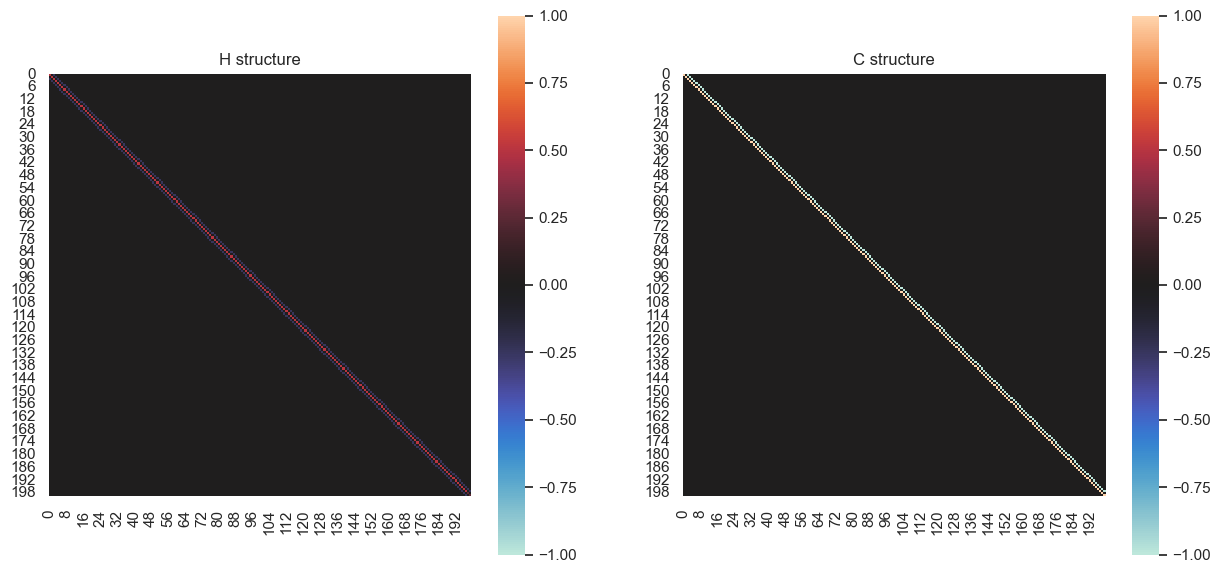

In [5]:
#plot structures of H and C:
fig, axs = plt.subplots(1,2,figsize=(15,7))

sns.heatmap(H, ax=axs[0], square=True, vmin=-1, vmax=1, cmap="icefire")
axs[0].set_title("H structure")

sns.heatmap(C, ax=axs[1], square=True, vmin=-1, vmax=1, cmap="icefire")
axs[1].set_title("C structure")

plt.show()

**This indicates potential use of sparse solvers**

## PART 1.4
### Solve problem using available solver packages:

In [6]:
#ONLY RUN CELL IF GUROBI IS INSTALLED!
m = gp.Model("part2")   #define model 

x = m.addMVar(shape=len(g), vtype=GRB.CONTINUOUS,name="x",lb=l,ub=u)    #add optimization variables with lower and upper bound 

cl = m.addConstr(C.T @ x >= dl, name="lb")  #add lower bound inequality constraints
cl = m.addConstr(-C.T @ x >= -du, name="ub")    #add upper bound inequality constraints

m.setObjective((1/2)*x.T @ H @ x + g.T @ x, GRB.MINIMIZE)   #set model objective

m.optimize()    #optimize the model


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 200 columns and 796 nonzeros
Model fingerprint: 0x93b191d3
Model has 20100 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 3e+01]
  QObjective range [3e-07, 5e-01]
  Bounds range     [1e+02, 3e+02]
  RHS range        [4e+01, 2e+02]
Presolve removed 202 rows and 0 columns
Presolve time: 0.02s
Presolved: 198 rows, 397 columns, 593 nonzeros
Presolved model has 20100 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 3.999e+04
 Factor NZ  : 5.861e+04 (roughly 1 MB of memory)
 Factor Ops : 1.130e+07 (less than 1 second

In [7]:
#np.save("gurobi_sol_ex2.npy",np.array(m.x))
sol_gurobi = np.load("gurobi_sol_ex2.npy")

**MISSING PLOTTING THE DATA**

In [15]:
#plotting data
output_mat = io.loadmat("plot_output.mat")

headers = list(output_mat.keys())[3:]

for h in headers:
    print(f"{h} shape: {output_mat[h].shape}, dtype: {output_mat[h].dtype}")

N shape: (1, 1), dtype: uint8
u_prev shape: (2, 1), dtype: float64
ys shape: (2, 1), dtype: float64
T shape: (1, 100), dtype: float64
x_kk shape: (6, 1), dtype: float64
C shape: (2, 6), dtype: float64
A shape: (6, 6), dtype: float64
B shape: (6, 2), dtype: float64
xs shape: (4, 1), dtype: float64
ds shape: (2, 1), dtype: uint8
zs shape: (2, 1), dtype: float64
us shape: (2, 1), dtype: uint16
R_k shape: (200, 1), dtype: float64


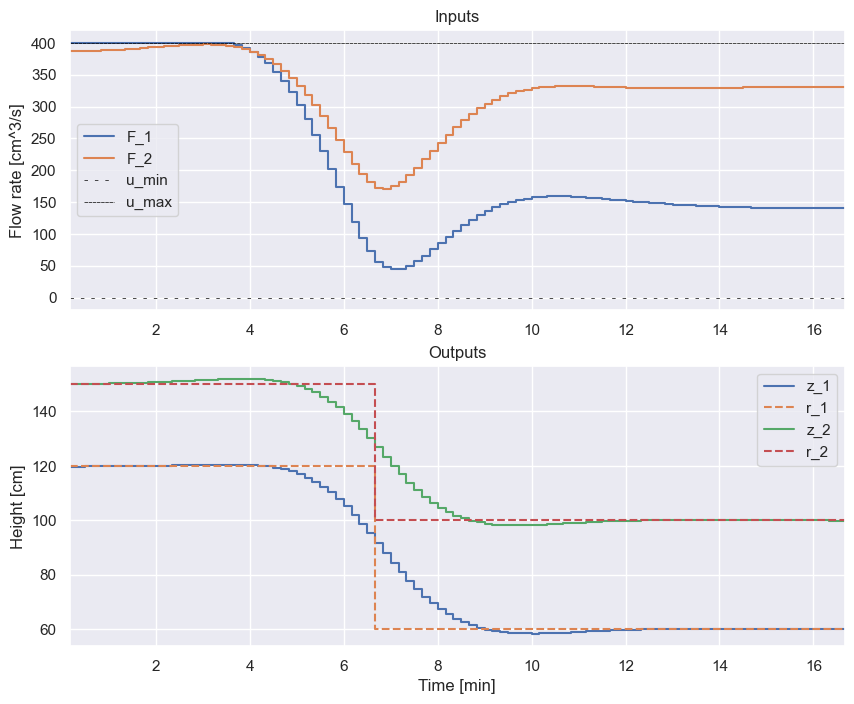

In [36]:
#replicate function in "PlotSolutionQP.m":
def plot_solution(U, data):
    mat = io.loadmat(data)
    N = mat["N"].flatten()[0]
    C = mat["C"]
    A = mat["A"]
    B = mat["B"]
    T = mat["T"].ravel()
    xx = mat["x_kk"].copy().ravel()

    u = U.reshape(100, 2)

    x = np.zeros((N,len(xx)))
    x[0] = xx
    z = np.zeros((N,2))
    z[0] = C @ xx
    for i in range(1,N):
        x[i] = A @ x[i-1] + B @ u[i-1]
        z[i] = C @ x[i]

    z = z + mat["zs"].astype(np.float64).ravel()
    u = u + mat["us"].astype(np.float64).ravel()
    r = mat["R_k"].reshape((100,2)) + mat["zs"].astype(np.float64).ravel()

    fig, ax = plt.subplots(2,1,figsize=(10,8))

    for i in range(2):
        ax[0].step(T, u[:,i], label=f"F_{i+1}")
        ax[1].step(T, z[:,i], label=f"z_{i+1}")
        ax[1].step(T, r[:,i], label=f"r_{i+1}", linestyle="--")
        ax[i].set_xlim([T.min(),T.max()])
    ax[0].axhline(y=0, label="u_min", color="black", linestyle=(0, (5, 10)), linewidth=0.5)
    ax[0].axhline(y=400, label="u_max", color="black", linestyle=(0, (5, 1)), linewidth=0.5)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Inputs")
    ax[1].set_title("Outputs")
    ax[0].set_ylabel("Flow rate [cm^3/s]")
    ax[1].set_ylabel("Height [cm]")
    ax[1].set_xlabel("Time [min]")

    plt.show()

plot_solution(sol_gurobi, "plot_output.mat")

### Helper functions

In [11]:
## -- function to construct kkt system -- ##
def kkt(H,g,A,b):
    m = A.shape[1]
    Z = np.zeros((m,m))
    if sparse.issparse(H):
        KKT = sparse.bmat([[H,-A],[-A.T,None]])
    else:
        KKT = np.block([[H,-A],[-A.T,Z]])
        
    return KKT, np.concatenate((-g,-b))

## -- function to solve equality constrained problem -- ##
#SHOULD BE REPLACED WITH FUNCTION FROM PART 1
def EqualityQPSolver(H,g,A,b):
    n = len(g)
    KKT, RHS = kkt(H,g,A,b)
    lu,piv = linalg.lu_factor(KKT)
    sol = linalg.lu_solve((lu,piv),RHS)
    return sol[:n], sol[n:]

In [12]:
def convert_to_standard(l, u, C, dl, du):
    '''
    converts problem:
        min 0.5x'Hx + g'x
        st. l <= x <= u
           dl <= C'x <= du

    to form:
        min 0.5x'Hx + g'x
        st. A'x >= b
    '''
    A = np.block([[np.eye(len(l))],[-np.eye(len(l))],[C.T],[-C.T]])
    b = np.concatenate((l,-u,dl,-du))
    return A.T, b

Initial point solver for active set QP (potentially for others aswell):

## PART 1.5
### Implementing active-set method:

In [13]:
#UNUSED FOR NOW
def initial_point_problem(A,b):
    A = A.T

    rows, cols = A.shape
    sys = np.block(([[A, np.ones(rows)[:,None], -np.eye(rows), np.zeros((rows,rows))],
                     [-A, np.ones(rows)[:,None], np.zeros((rows,rows)), -np.eye(rows)]]))
    
    rhs = np.concatenate((b,-b))

    return sys, rhs

Using big M form we transform the problem into:

$\mathrm{min}\, 0.5\begin{bmatrix} x \\ t \end{bmatrix}^\top \begin{bmatrix} H & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ t \end{bmatrix} + \begin{bmatrix} g \\ M \end{bmatrix}^\top \begin{bmatrix} x \\ t \end{bmatrix}$

st.      $\begin{bmatrix} A & 1 \\ 0 & 1 \end{bmatrix} \geq \begin{bmatrix} b \\ 0 \end{bmatrix}$

In [14]:
#Convert problem to big M form for active set method
def bigM_form(H,g,A,b,M):
    n, m = A.shape
    H = np.block([[H,np.zeros(n)[:,None]],[np.zeros(n+1)]])
    H[-1,-1] = 1
    g = np.concatenate((g,[M]))
    sys = np.block([[A,np.zeros(n)[:,None]],[np.ones(m+1)]])
    return H, g, sys, np.concatenate((b,[0]))

Primal Active set algorithm for convex QP:

In [15]:
def CQP_solver_active(H ,g , A, b, x0, max_iter = 100, tol=1e-8, solver="LUdense", verbose=False, save_it=False):
    """
    Active Set algorithm for convex QPs of form:

        min 0.5x'Hx + g'x
        st. A'x >= b

    ---------------------------------------------

    parameters:
    ___________
        H : H matrix of convex obj function
        g : g vector of convex obj function
        A : Constraints matrix
        b : contstraints RHS
        x0 : starting point
        max_iter : optional max iterations
    ___________
    output:
    ___________
        x : minimum of CQP
        lambdas : lambdas of constraints
        active_set : active set of constraints
        k : iterations needed to solve problem
        converged: bool if converged or not
    """

    converged = False
    indx = np.arange(len(b))                #index list for constraints
    ws = np.zeros(len(b)).astype(np.bool_)  #boolean list working set

    xks = np.zeros((max_iter,len(x0)))      #store x iterations
    wss = np.zeros((max_iter,len(ws)))      #store working set iterations
    lambdass = np.zeros((max_iter,len(b)))  #store lagrange multiplier iterations

    if np.any(A.T @ x0 < b):
        raise ValueError("Initial point is not feasible!")

    x = x0

    for i in range(max_iter):

        xks[i] = x

        #define working sets
        Aw, bw = A[:,ws], b[ws]

        #solve following problem: | H -Aw||pk| = -|Hx + g|
        #                         |-Aw' 0||la|    |   0  |
        # for search direction pk and lagrange multipliers la:
        pk, lambdass[i,ws] = EqualityQPSolver(H, (H @ x + g), Aw, np.zeros(len(bw)))

        #if |pk| is zero:
        if np.allclose(pk,0, rtol=tol):

            #if all lagrange multipliers >= 0, then algorithm has converged
            if np.all(lambdass[i] >= 0):
                converged = True
                break
            else:
                #exit constraint with most negative lagrange multiplier
                j = np.argmin(lambdass[i])
                ws[j] = False
                if verbose: print(f"exiting constraint: {j}")

        #if |pk| is non-zero, then step in that direction should be taken:
        else:

            #calculate maximum step-size
            alphas = np.zeros(len(b))
            m = (A.T @ pk < 0) & ~ws
            alphas[m] = (b[m] - A.T[m] @ x) / (A.T[m] @ pk)
            alpha = min(1,np.min(alphas[m]))

            #update x
            x = x + alpha*pk

            #enter blocking constraint into working set if alpha < 1:
            if alpha < 1:
                blocking = np.argmin(alphas[m])
                block_indx = indx[m][blocking]
                if verbose: print(f"entering constraint: {block_indx}")
                ws[block_indx] = True

    return x, xks[:i+1], lambdass[:i+1], wss[:i+1], i, converged

In [16]:
#convert to form st. A'x >= b
A, b = convert_to_standard(l,u,C,dl,du)

#Convert problem to big M form to find initial feasible point:
#M is chosen small in the start, if t is non zero at final solution,
# M is increased and the problem is resolved until t is 0.

M = 2
times = []
t_is_0 = False
time_active = 0
t1_tot = time.perf_counter()
while not t_is_0:
    Ha, ga, Aa, ba = bigM_form(H,g,A,b,M)
    x0 = np.concatenate((u - l, [0]))
    t = np.max(Aa.T @ x0)
    x0[-1] = t

    t1 = time.perf_counter()
    sol_active, xks, lambdaks, wks, iter_active, converged = CQP_solver_active(Ha,ga,Aa,ba,x0, max_iter = 1000)
    t2 = time.perf_counter()

    if np.allclose(sol_active[-1],0):
        t_is_0 = True
        time_active = t2-t1
        print(f"solved successfully with M = {M}")
        print(f"    solved in {time_active}s,")
        print(f"    and {iter_active+1} iterations.")
    else:
        M = M*2
t2_tot = time.perf_counter()

time_active_total = t2_tot - t1_tot
print(f"Total time: {time_active_total}s")

solved successfully with M = 4
    solved in 0.034751399885863066s,
    and 24 iterations.
Total time: 0.09522770019248128s


In [17]:
#Compare objective values with commercial solver:
#gurobi gave objective of -49341.9075
obj_active = 0.5*sol_active[:-1].T @ H @ sol_active[:-1] + g.T @ sol_active[:-1]
print(f"Objective value of active set method: {obj_active}")

Objective value of active set method: -49341.90751270984


In [18]:
#Compare x values:
print(np.allclose(sol_gurobi,sol_active[:-1]))

True


## PART 1.8
### Implement primal-dual interior-point algorithm:

In [19]:
#initial point heuristics for primal-dual interior-point algorithm:
#defined on slide 29 of "Interior Point Algorithm for QP" (lecture 6)
def primal_dual_initial(H,g,A,b):
    n, m = A.shape
    x_bar = np.zeros(n)
    z_bar = np.ones(m)/m
    s_bar = np.ones(m)/m

    rL = H @ x_bar + g - A @ z_bar
    rA = s_bar + b - A.T @ x_bar
    rSZ = s_bar * z_bar

    H_bar = H + (A * (z_bar / s_bar)) @ A.T
    lu_fac = linalg.lu_factor(H_bar)

    rL_bar = rL - (A * (z_bar / s_bar)) @ (rA - rSZ/z_bar)

    dx_aff = linalg.lu_solve(lu_fac, -rL_bar)
    
    dz_aff = - ((z_bar / s_bar)[:,None] * A.T) @ dx_aff + (z_bar / s_bar)*(rA - rSZ / z_bar)
    ds_aff = - rSZ / z_bar - s_bar / z_bar * dz_aff

    z = np.maximum(1,np.abs(z_bar + dz_aff))
    s = np.maximum(1,np.abs(s_bar + ds_aff))

    return x_bar, z, s

In [22]:
def primal_dual_interior(H,g,A,b, x0=None, z0=None, s0=None, max_iter=100, tol=10e-8, verbose=False):
    '''
    Primal-dual interior point algorithm for convex QPs of form:

        min 0.5x'Hx + g'x
        st. A'x >= b

    based on algorithm given on slide 28 of 
    "Interior Point Algorithm for QP" (lecture 6)
    ---------------------------------------------

    parameters:
    ___________
        H : H matrix of convex obj function
        g : g vector of convex obj function
        A : Constraints matrix
        b : contstraints RHS
        x0 : starting point
        z0 : initial lagrange multipliers
        s0 : intital slack variables
        max_iter : optional max iterations
        tol : tolerance for stopping criteria
    ___________
    output:
    ___________
        x : optimal x
        xks : x iterations
        iter : iteration at convergence
        converged: bool if converged or not 
    '''
    n, m = A.shape

    #compute initial point
    if x0 is None:
        x0, z0, s0 = primal_dual_initial(H,g,A,b)

    xks = np.zeros((max_iter+2,n))
    zks = np.zeros((max_iter+2,m))
    sks = np.zeros((max_iter+2,m))

    x = x0
    z = z0
    s = s0

    z_ratio = np.ones(m)
    s_ratio = np.ones(m)

    #define residuals
    rL = H @ x + g - A @ z
    rA = s + b - A.T @ x
    rSZ = s * z
    mu = np.dot(s,z)/m

    converged = False
    iter = 0

    #define stopping conditions:
    rL_cond = tol * max(1, H.max(), g.max(), A.max())
    rA_cond = tol * max(1, b.max(), A.max())
    mu_cond = tol * 10e-2 * mu

    if verbose:
        print(f"rL_cond: {rL_cond}")
        print(f"rA_cond: {rA_cond}")
        print(f"mu_cond: {mu_cond}")

    while not converged and iter < max_iter:
        if verbose: print(f"iteration: {iter}\n")

        xks[iter] = x
        zks[iter] = z
        sks[iter] = s

        #construct augmented matrix
        H_bar = H + (A * (z / s)) @ A.T

        #compute factorization
        lu_fac = linalg.lu_factor(H_bar)

        # affine direction
        rL_bar = rL - (A * (z / s)) @ (rA - rSZ/z)
        dx_aff = linalg.lu_solve(lu_fac, -rL_bar)

        dz_aff = - ((z / s)[:,None] * A.T) @ dx_aff + (z / s) * (rA - rSZ / z)
        ds_aff = - (rSZ / z) - s / z * dz_aff

        #compute affine step size
        z_ratio_aff = np.where(-z/dz_aff <= 0, 1, -z/dz_aff)
        s_ratio_aff = np.where(-s/ds_aff <= 0, 1, -s/ds_aff)
        alpha_aff = min(1, z_ratio_aff.min(), s_ratio_aff.min())

        #compute affine duality gap
        mu_aff = (z + alpha_aff * dz_aff).T @ (s + alpha_aff * ds_aff) / m

        #compute centering parameter
        sigma = (mu_aff / mu) ** 3

        #affine centering-correction step
        rSZ_bar = rSZ + ds_aff * dz_aff - sigma * mu * np.ones(m)

        rL_bar = rL - (A * (z / s)) @ (rA - rSZ_bar/z)
        
        #compute step directions
        dx = linalg.lu_solve(lu_fac, -rL_bar)
        dz = - ((z / s)[:,None] * A.T) @ dx + (z / s)*(rA - rSZ_bar / z)
        ds = - rSZ_bar / z - s / z * dz

        #compute step size
        z_ratio = np.where(-z/dz <= 0, 1, -z/dz)
        s_ratio = np.where(-s/ds <= 0, 1, -s/ds)
        alpha = min(1, z_ratio.min(), s_ratio.min())

        eta = 0.995
        alpha_bar = eta * alpha

        #update iterates
        x = x + alpha_bar * dx
        z = z + alpha_bar * dz
        s = s + alpha_bar * ds
        
        #recompute residuals
        rL = H @ x + g - A @ z
        rA = s + b - A.T @ x
        rSZ = s * z
        mu = np.dot(s,z)/m

        iter += 1

        #check convergence conditions
        if abs(rL.max()) <= rL_cond and abs(rA.max()) <= rA_cond and mu <= mu_cond:
            converged = True
            xks[iter] = x
            zks[iter] = z
            sks[iter] = s    
    
    return x, xks, zks, sks, iter, converged

In [23]:
#reload data just in case
data = io.loadmat("QP_Test.mat")

H = data["H"]
g = data["g"].ravel()
C = data["C"].astype(np.float64)
dl = data["dl"].ravel()
du = data["du"].ravel()
l = data["l"].ravel().astype(np.float64)
u = data["u"].ravel().astype(np.float64)

A, b = convert_to_standard(l,u,C,dl,du)

In [32]:
t1 = time.perf_counter()
sol_interior, xks, zks, sks, iter_interior, converged = primal_dual_interior(H,g,A,b, tol=1e-14, max_iter=100)
t2 = time.perf_counter()

time_interior = t2-t1

print(f"time elapsed: {time_interior}s")
print(f"solved in {iter_interior} iterations")

time elapsed: 0.08087299996986985s
solved in 14 iterations


In [33]:
interior_obj = 0.5 * sol_interior.T @ H @ sol_interior + g.T @ sol_interior
print(f"Objective value of primal-dual interior-point algorithm: {interior_obj}")

Objective value of primal-dual interior-point algorithm: -49341.90751270502


In [34]:
#Compare x values:
print(np.allclose(sol_gurobi,sol_interior))

True


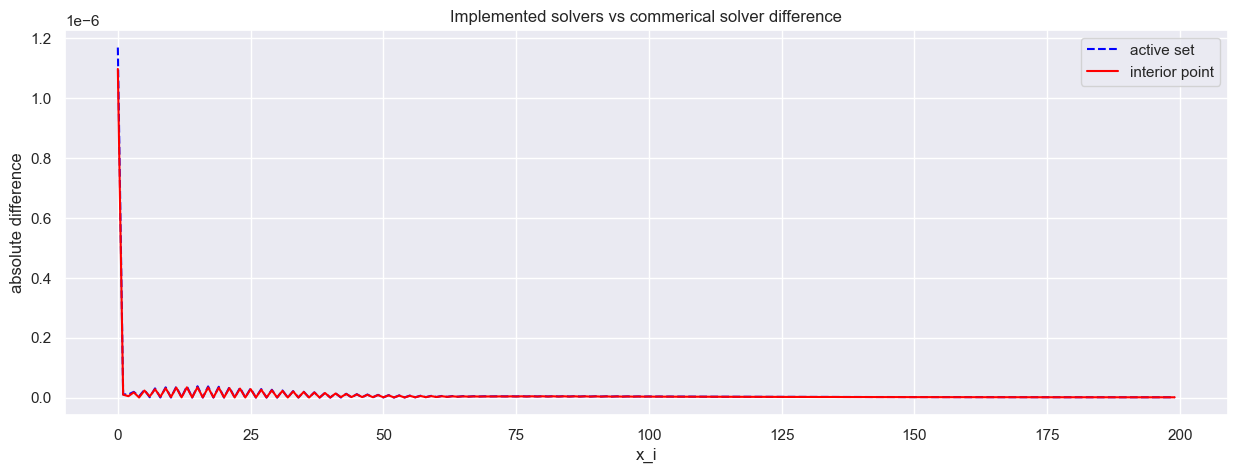

In [35]:
fig, axs = plt.subplots(figsize=(15,5))

xs = np.arange(len(g))
axs.plot(xs, np.abs(sol_active[:-1] - sol_gurobi), linestyle="dashed", color="blue", label="active set")
axs.plot(xs, np.abs(sol_interior - sol_gurobi), linestyle="-", color="red", label="interior point")
axs.legend()
axs.set_xlabel("x_i")
axs.set_ylabel("absolute difference")
plt.title("Implemented solvers vs commerical solver difference")
plt.show()